# Sequence Instructed Task Analysis Demo

This notebook demonstrates the refactored analysis utilities for the sequence instructed timing task.

**Features:**
- Load trained model and generate data
- Compute psychometric curves (rule-specific)
- Perform PCA on full trial sequences
- Perform period-specific PCA (ITI, rule report, decision)
- Create static 2D and 3D visualizations
- Create animated trajectory visualizations
- Save all plots to `analysis/plots/`

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from IPython.display import HTML

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

from config import Config
from analysis.utils import (
    perform_pca,
    perform_period_pca,
    compute_psychometric_curves,
    visualize_pca,
    animate_pca,
    get_metadata,
    plot_batch_trials,
    plot_cross_period_variance,
    generate_data,
)

plt.rcParams['figure.dpi'] = 100

## 1. Load Model and Task

In [3]:
checkpoint_path = Path('../logs/instructed_timing/checkpoint_step_6000.pt')
config_path = checkpoint_path.parent / 'config.yaml'

config = Config.from_yaml(str(config_path))

# Create task and model
task= config.create_task(discrete_eval=True)
model = config.create_model()

# Load model weights
checkpoint = torch.load(checkpoint_path, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nLoaded model from {checkpoint_path}")
print(f"Training step: {checkpoint['step']}")
print(f"Hidden size: {model.hidden_size}")
print(f"Tau: {model.tau} ms")
print(f"Noise std: {model.noise_std}")


Loaded model from ../logs/instructed_timing/checkpoint_step_6000.pt
Training step: 6000
Hidden size: 128
Tau: 100.0 ms
Noise std: 0.05


Generating trial data with reward feedback...
Generated 200 trials × 5 channels × 442 timesteps
Hidden states shape: torch.Size([200, 128, 442])

Plotting sample trials...


IndexError: index 2 is out of bounds for dimension 1 with size 2

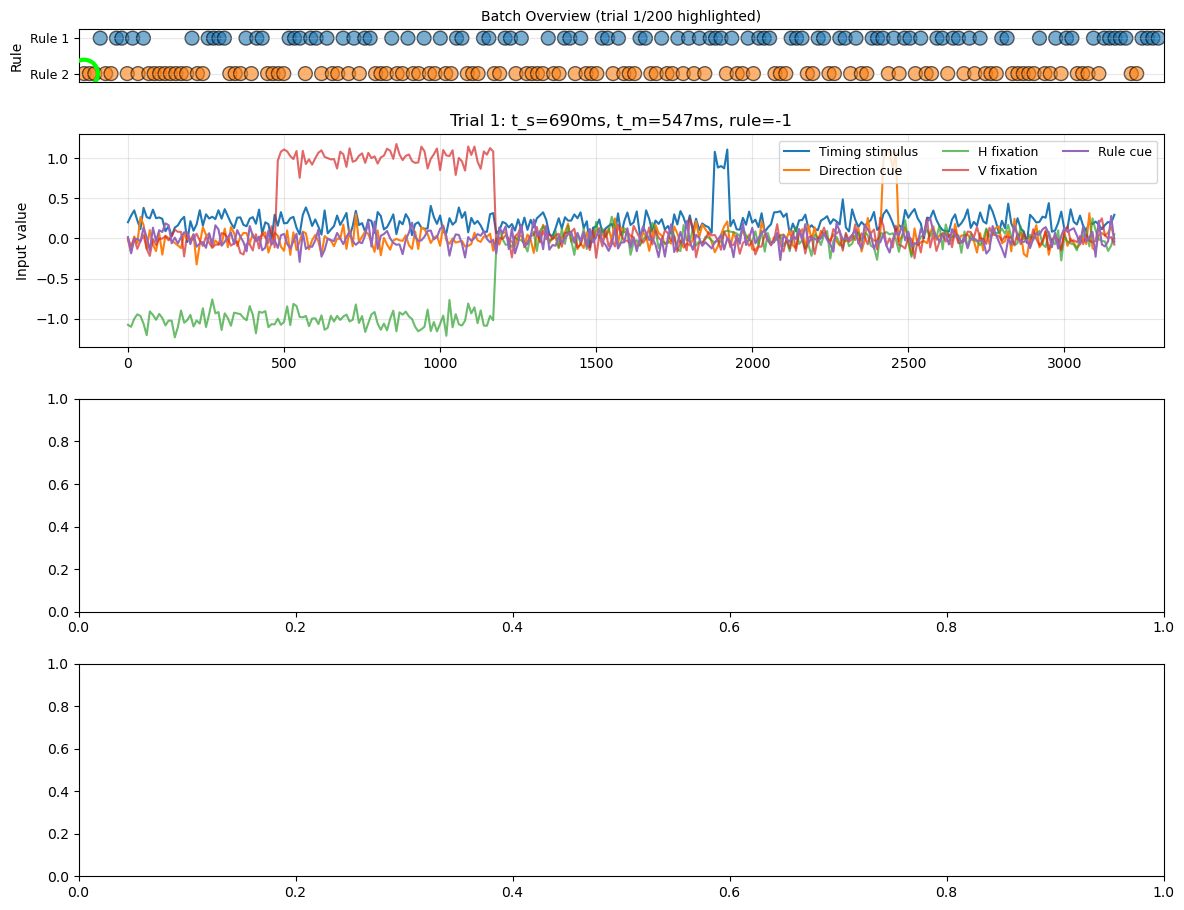

In [4]:
# Generate data with proper reward feedback across trials
print("Generating trial data with reward feedback...")
data = generate_data(task=task, model=model, num_trials=200)

inputs = data['inputs']
outputs = data['outputs']
hidden_states = data['hidden_states']
batch = data['batch']

N, C, T_max = inputs.shape
print(f"Generated {N} trials × {C} channels × {T_max} timesteps")
print(f"Hidden states shape: {hidden_states.shape}")

# Reconstruct batch with batch dimension for plotting
batch_for_plot = {}
for key, value in batch.items():
    if isinstance(value, (torch.Tensor, np.ndarray)):
        # Add batch dimension
        if isinstance(value, torch.Tensor):
            batch_for_plot[key] = value.unsqueeze(0)
        else:
            batch_for_plot[key] = np.expand_dims(value, axis=0)
    else:
        batch_for_plot[key] = value

# Add inputs to batch
batch_for_plot['inputs'] = inputs.unsqueeze(0)

# Plot a few trials to visualize the data
print("\nPlotting sample trials...")
trial_figs = plot_batch_trials(
    batch=batch_for_plot,
    outputs=outputs,
    targets=batch['targets'],
    task=task,
    num_trials=2
)
plt.show()

## 2. Psychometric Curves (Rule-Specific)

In [4]:
# Compute psychometric curves for both rules
print("Computing psychometric curves...")
psych_results = compute_psychometric_curves(
    task=task,
    model=model,
    num_trials_per_interval=100,
    rules=[1, -1],
)

intervals = psych_results['intervals']
rule1_acc = psych_results['accuracies'][1]
rule1_pro = psych_results['pro_probs'][1]
rule2_acc = psych_results['accuracies'][-1]
rule2_pro = psych_results['pro_probs'][-1]

print(f"Rule 1 mean accuracy: {rule1_acc.mean():.3f}")
print(f"Rule 2 mean accuracy: {rule2_acc.mean():.3f}")

# Plot psychometric curves from plotting module

Computing psychometric curves...
Rule 1 mean accuracy: 0.902
Rule 2 mean accuracy: 0.889


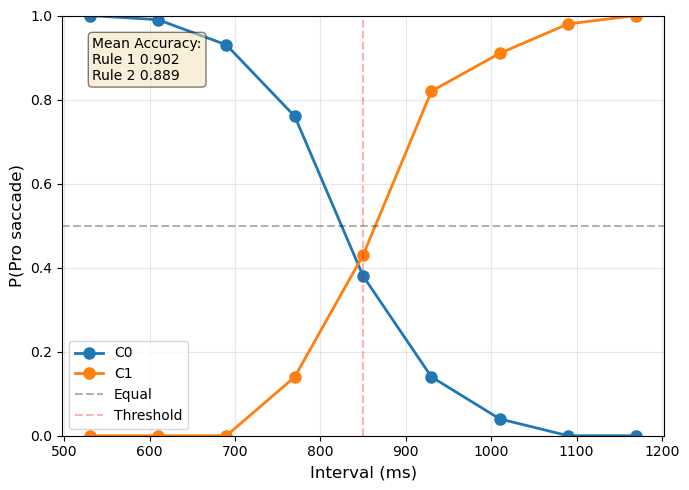

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(intervals, rule1_pro, 'o-', linewidth=2, markersize=8, label='C0')
ax.plot(intervals, rule2_pro, 'o-', linewidth=2, markersize=8, label='C1')
ax.axhline(0.5, color='k', linestyle='--', alpha=0.3, label='Equal')
ax.axvline(task.decision_threshold, color='r', linestyle='--', alpha=0.3, label='Threshold')
ax.set_xlabel('Interval (ms)', fontsize=12)
ax.set_ylabel('P(Pro saccade)', fontsize=12)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend()
# Add accuracy annotation
ax.text(0.05, 0.95, f'Mean Accuracy:\nRule 1 {rule1_acc.mean():.3f}\nRule 2 {rule2_acc.mean():.3f}',
        transform=ax.transAxes, verticalalignment='top',
        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 3. Full-Trial PCA Analysis

In [5]:
# Perform PCA on hidden states
print("Performing PCA...")
pca_data, explained_var, pcs, mean = perform_pca(hidden_states, n_components=3)

print(f"Explained variance (first 3 PCs): {explained_var}")
print(f"Cumulative variance: {explained_var.cumsum()}")

# Extract metadata for visualization using helper function
trial_lengths = batch['trial_length']
metadata = get_metadata(batch, outputs=outputs, task=task)

print(f"\nMetadata extracted for {len(trial_lengths)} trials")
print(f"Metadata keys: {list(metadata.keys())}")

Performing PCA...
Explained variance (first 3 PCs): [0.5560305  0.17476635 0.07879198]
Cumulative variance: [0.5560305  0.7307969  0.80958885]

Metadata extracted for 200 trials
Metadata keys: ['rule', 't_m', 't_s', 'stim_direction', 'decision']


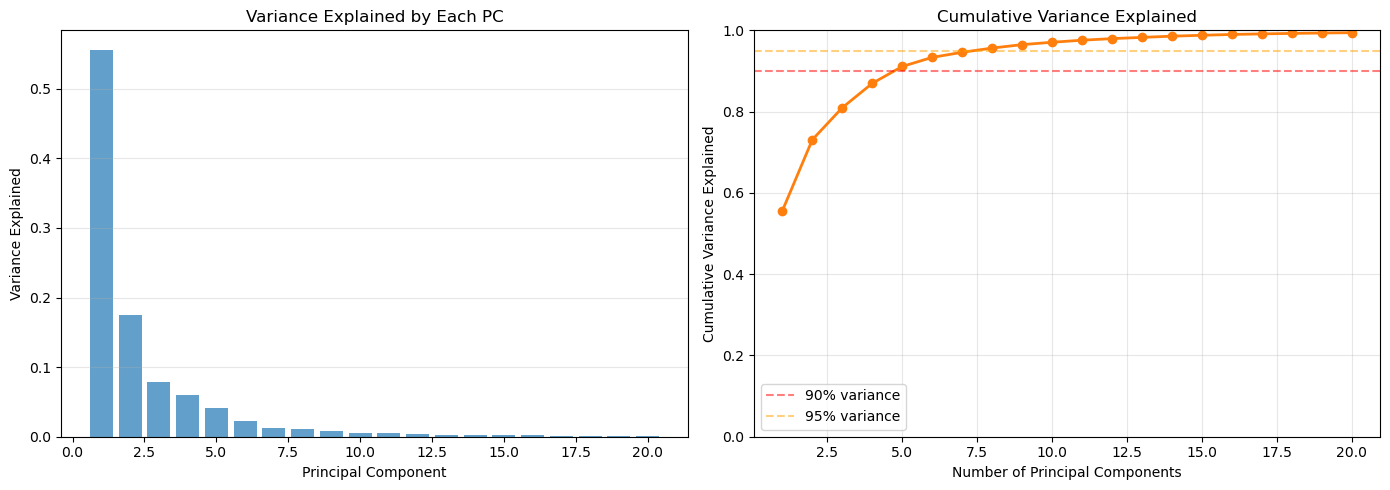

In [6]:
# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get all eigenvalues for full spectrum
_, all_explained_var, _, _ = perform_pca(hidden_states, n_components=min(20, hidden_states.shape[1]))

# Individual variance
ax = axes[0]
ax.bar(range(1, len(all_explained_var)+1), all_explained_var, alpha=0.7, color='C0')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title('Variance Explained by Each PC')
ax.grid(True, alpha=0.3, axis='y')

# Cumulative variance
ax = axes[1]
cumulative_var = np.cumsum(all_explained_var)
ax.plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-', linewidth=2, markersize=6, color='C1')
ax.axhline(0.9, color='r', linestyle='--', alpha=0.5, label='90% variance')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='95% variance')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Variance Explained')
ax.set_title('Cumulative Variance Explained')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

### 3.2 Static 2D Visualization - Colored by Rule

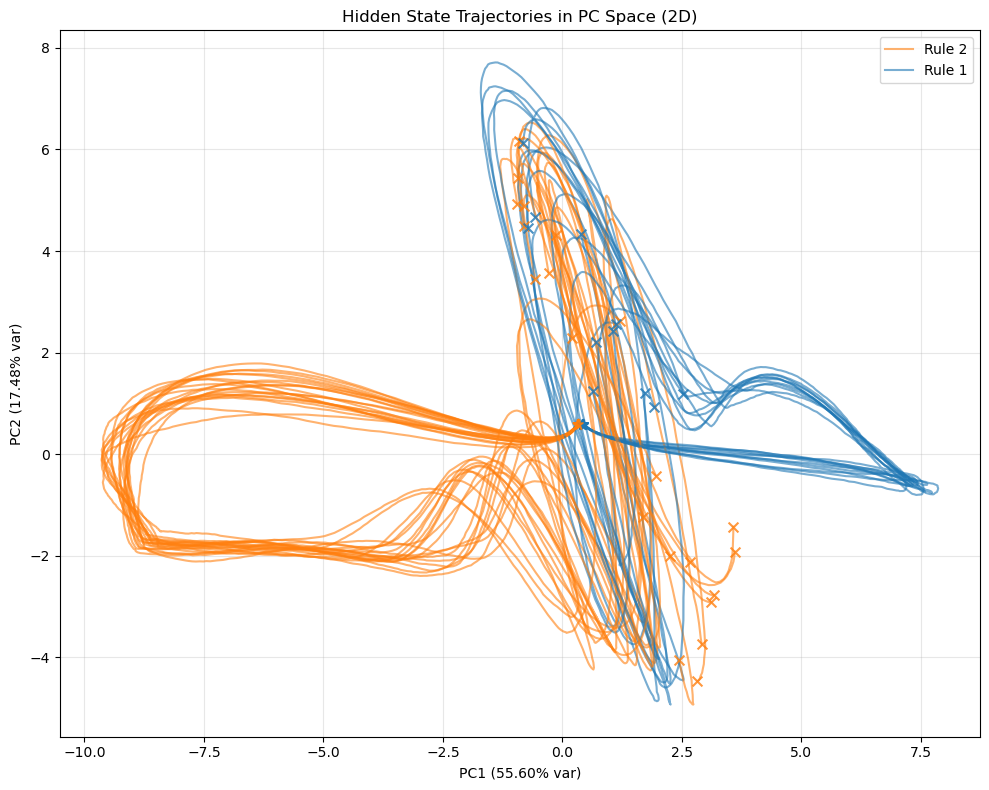

In [13]:
# Create 2D static visualization
fig, ax = visualize_pca(
    pca_data=pca_data,
    explained_variance=explained_var,
    trial_lengths=trial_lengths,
    metadata=metadata,
    plot_3d=False,
    num_trials=32,
    color_by='rule',
    figsize=(10, 8),
    save_path=None
)
plt.show()

### 3.3 3D Visualization 

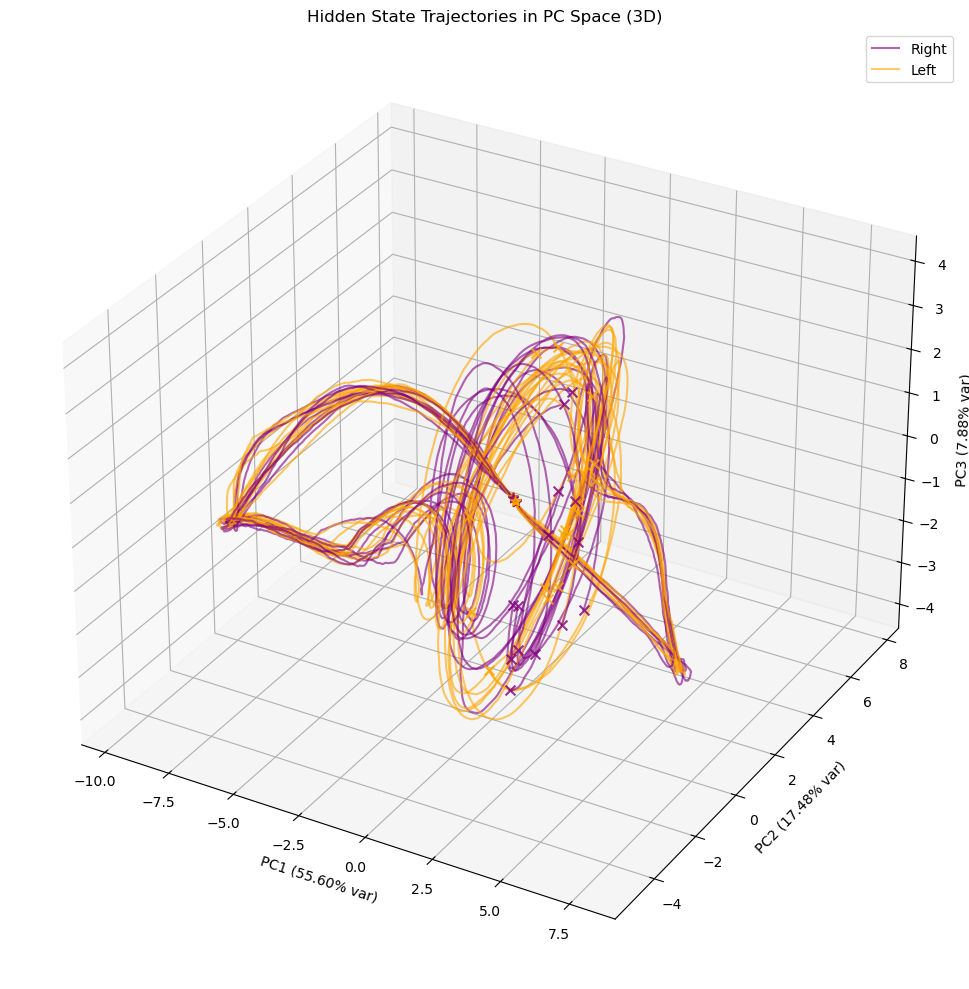

In [27]:
# Create 3D static visualization
fig, ax = visualize_pca(
    pca_data=pca_data,
    explained_variance=explained_var,
    trial_lengths=trial_lengths,
    metadata=metadata,
    plot_3d=True,
    num_trials=32,
    color_by='stim_direction',
    figsize=(12, 10),
)
plt.show()

## 4. Period-Specific PCA Analysis

Analyze different trial periods separately:
- **ITI** (Inter-Trial Interval): Initial settling period
- **Rule Report**: Rule cue presentation and response
- **Timing**: Timing stimulus presentation (first pulse to second pulse end)
- **Decision**: Decision response period

In [18]:
# Perform period-specific PCA
print("Performing period-specific PCA...")
period_results = perform_period_pca(
    hidden_states=hidden_states,
    batch=batch,
    period_names=['rule_report', 'timing', 'decision'],
    task=task,
    n_components=3
)

# Print variance explained for each period
for period_name, results in period_results.items():
    var = results['explained_variance_ratio']
    max_len = max(results['period_lengths'])
    print(f"\n{period_name.upper()} Period:")
    print(f"  Explained variance (PC1-3): {var}")
    print(f"  Cumulative: {var.cumsum()}")
    print(f"  Max length: {max_len} timesteps ({max_len*task.dt:.0f}ms)")

Performing period-specific PCA...

RULE_REPORT Period:
  Explained variance (PC1-3): [0.86810397 0.05684909 0.03441501]
  Cumulative: [0.86810397 0.92495307 0.95936808]
  Max length: 160 timesteps (1600ms)

TIMING Period:
  Explained variance (PC1-3): [0.56689831 0.21670507 0.06377821]
  Cumulative: [0.56689831 0.78360337 0.84738158]
  Max length: 122 timesteps (1220ms)

DECISION Period:
  Explained variance (PC1-3): [0.50254304 0.22850607 0.09370169]
  Cumulative: [0.50254304 0.73104911 0.8247508 ]
  Max length: 70 timesteps (700ms)


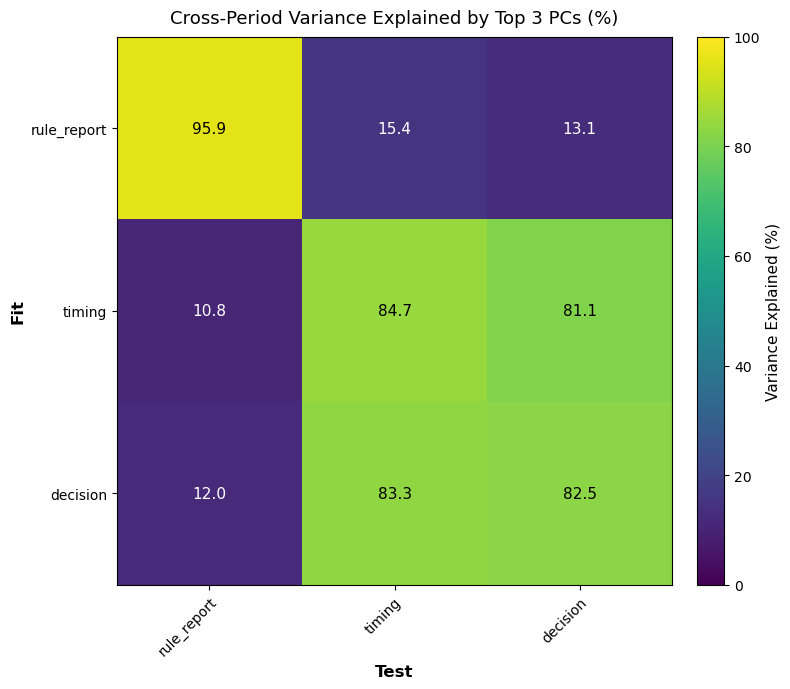

In [19]:
# Plot cross-period variance explained
fig, ax = plot_cross_period_variance(period_results, figsize=(8, 7), save_path=None)
plt.show()

### 4.2 Rule Report Period

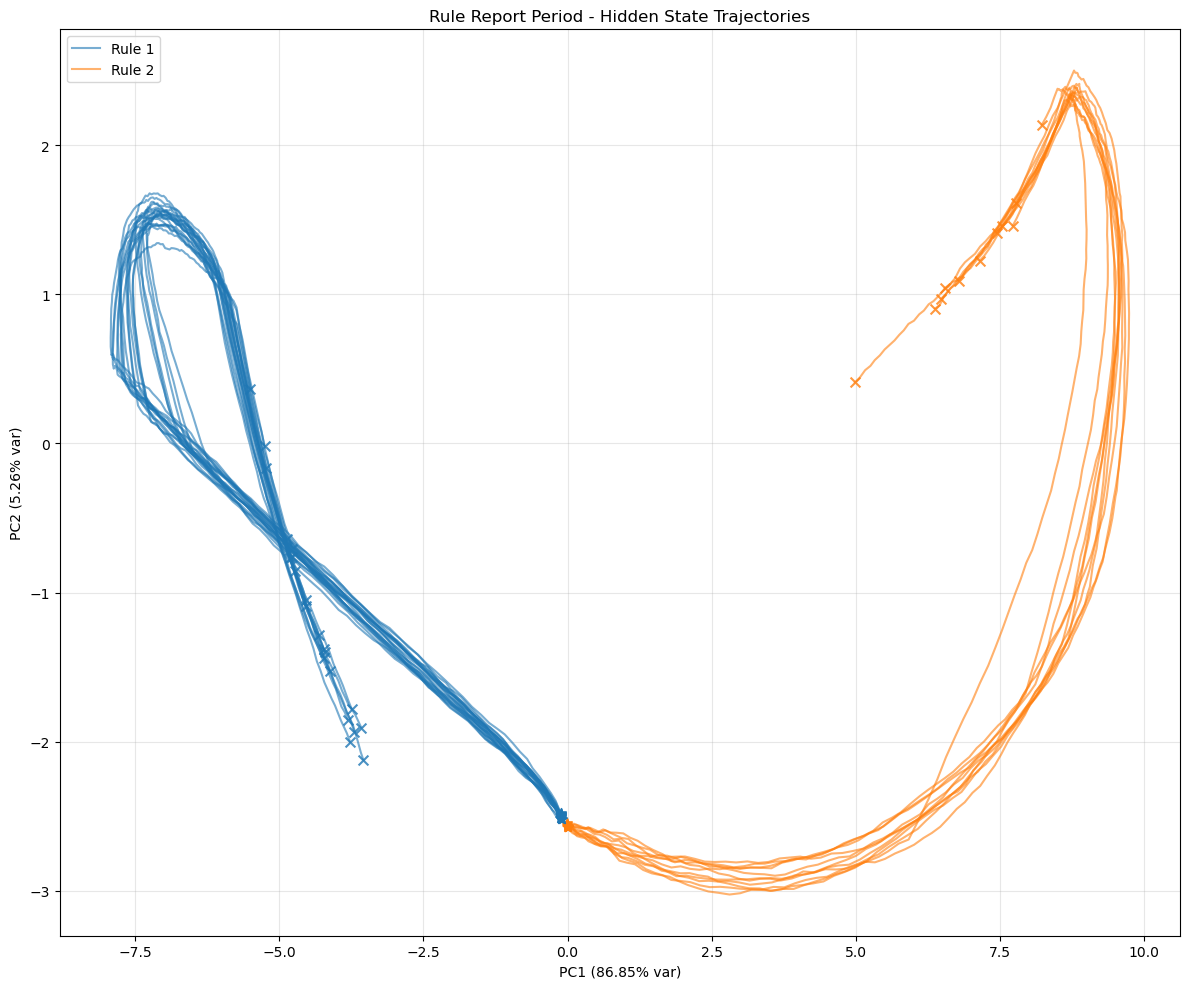

In [13]:
# Visualize rule report period
rule_results = period_results['rule_report']

fig, ax = visualize_pca(
    pca_data=rule_results['pca_data'],
    explained_variance=rule_results['explained_variance_ratio'],
    trial_lengths=rule_results['period_lengths'],
    metadata=metadata,
    plot_3d=False,
    num_trials=32,
    color_by='rule',
    figsize=(12, 10),
)
ax.set_title('Rule Report Period - Hidden State Trajectories')
plt.show()

### 4.3 Timing Period

Creating Timing animation...


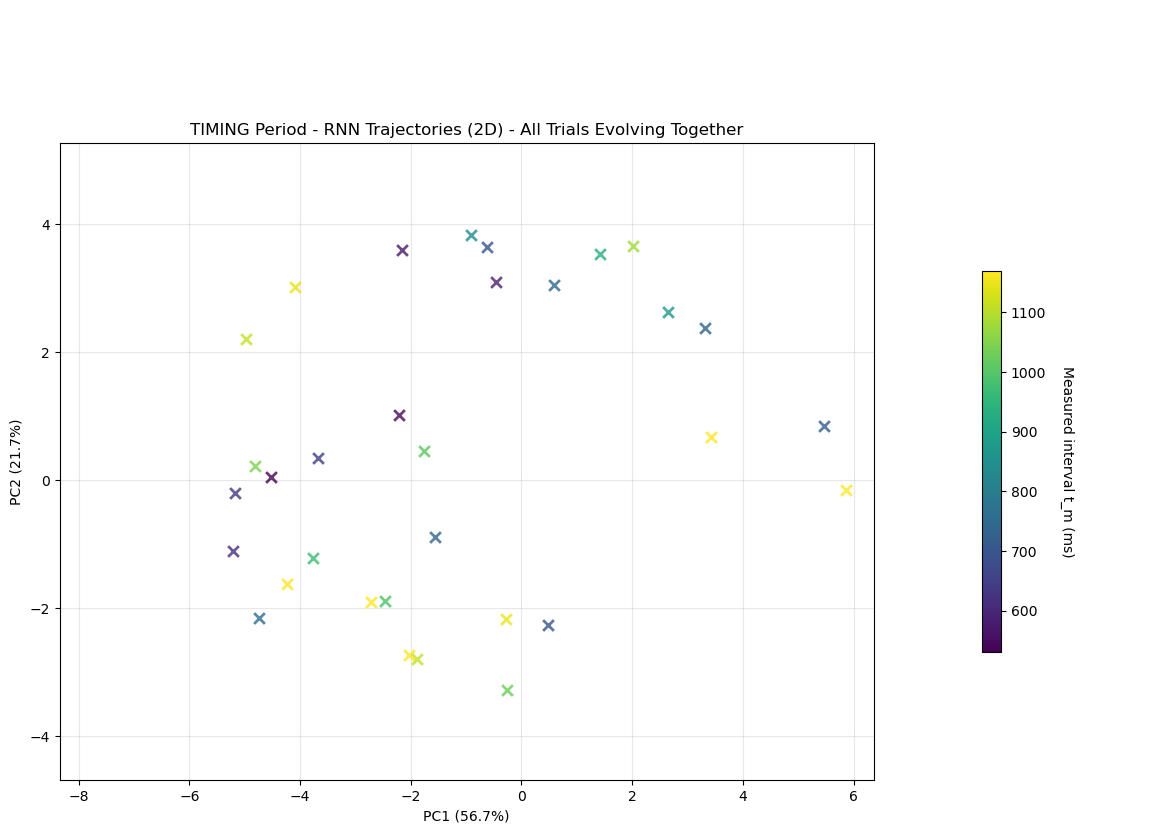

In [22]:
# Visualize timing period
timing_results = period_results['timing']

print("Creating Timing animation...")
anim_timing = animate_pca(
    pca_data=timing_results['pca_data'],
    explained_variance=timing_results['explained_variance_ratio'],
    period_lengths=timing_results['period_lengths'],
    metadata=metadata,
    period_name='Timing',
    plot_3d=False,
    plot_simultaneously=True,
    color_by='t_m',
    num_trials=32,
    interval=50
)

HTML(anim_timing.to_html5_video())

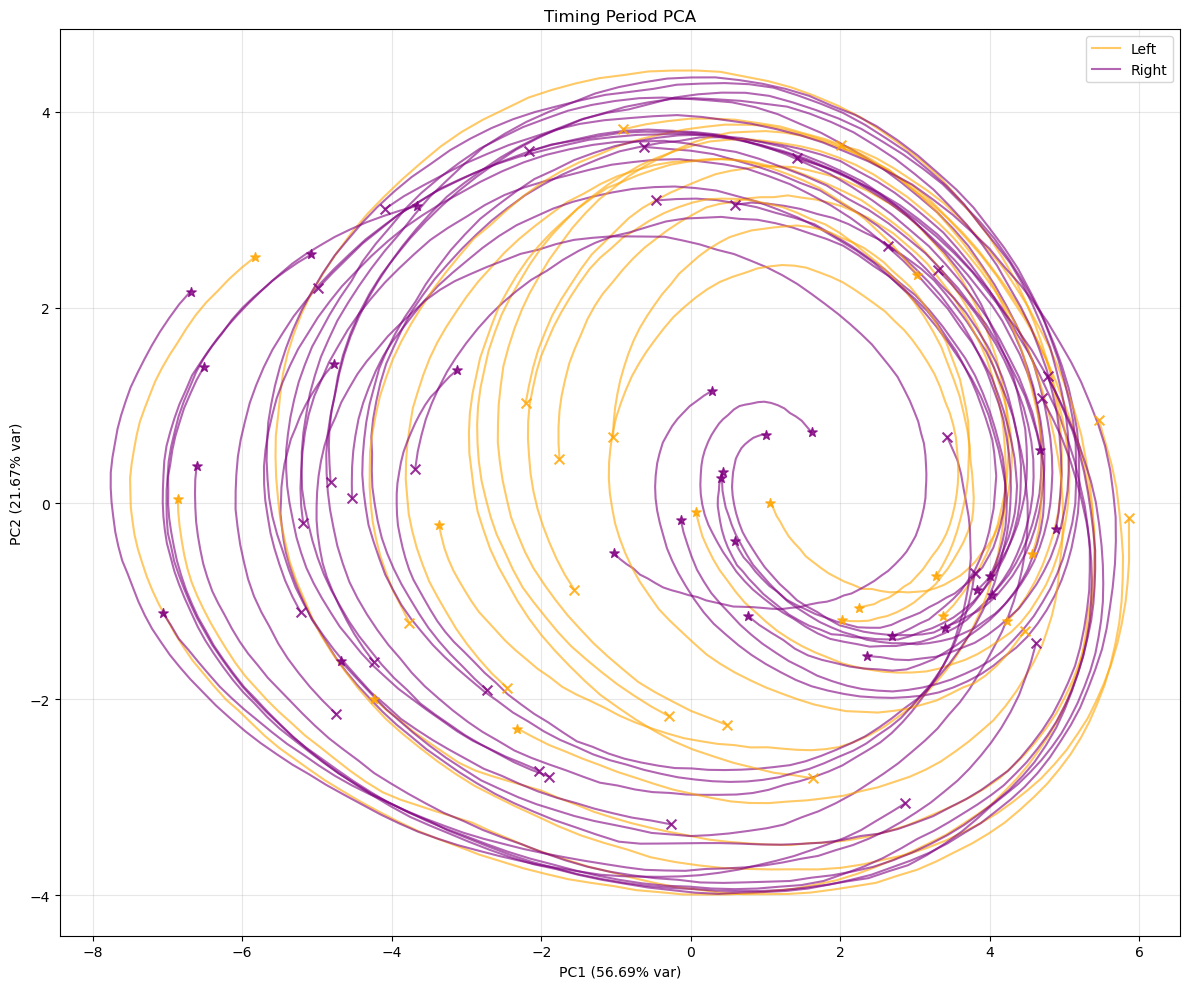

In [23]:
# Visualize timing period colored by actual time

fig, ax = visualize_pca(
    pca_data=timing_results['pca_data'],
    explained_variance=timing_results['explained_variance_ratio'],
    trial_lengths=timing_results['period_lengths'],
    metadata=metadata,
    plot_3d=False,
    num_trials=40,
    color_by='decision',
    figsize=(12, 10)
)
plt.title('Timing Period PCA')
plt.show()

### 4.4 Decision Period

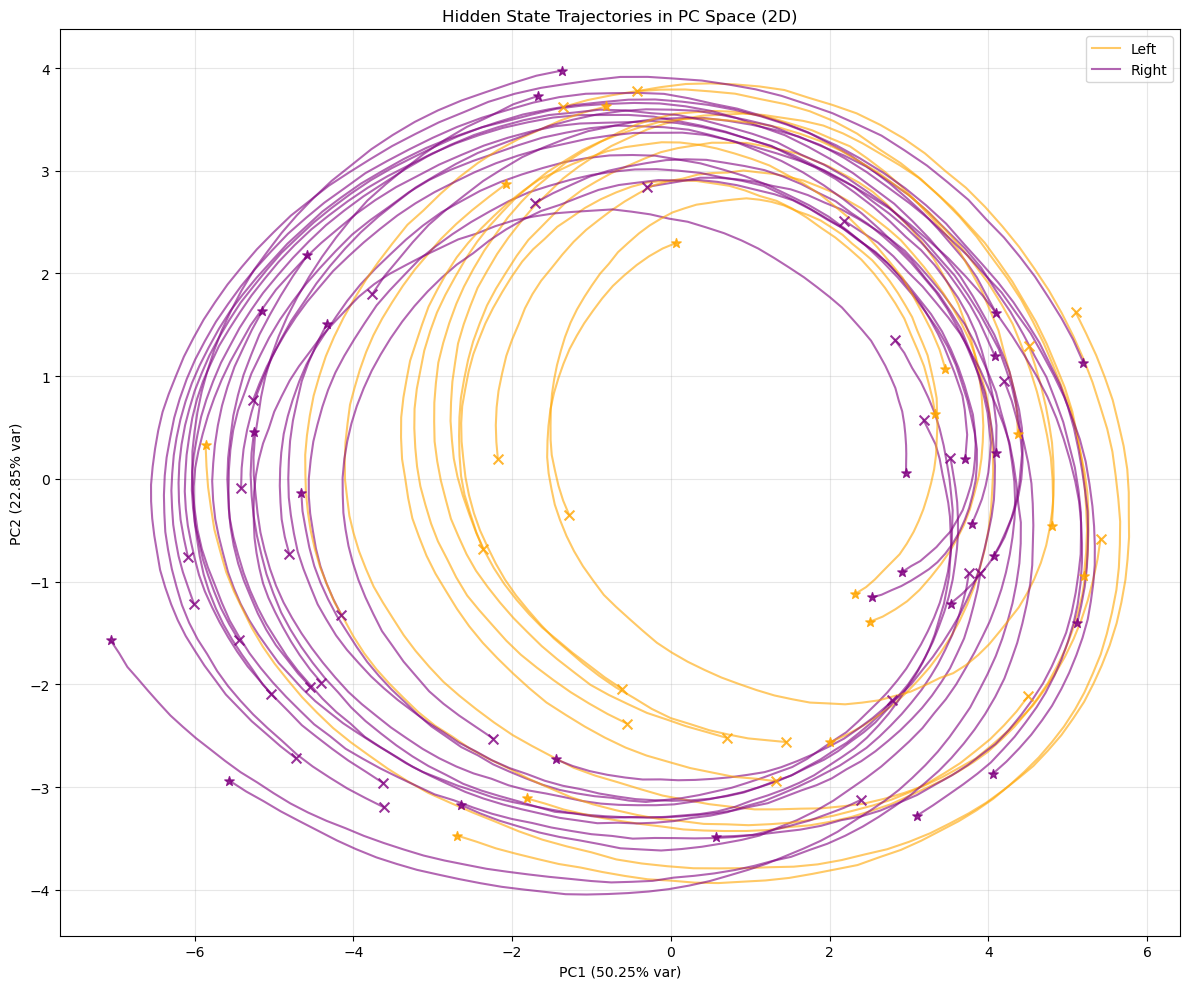

In [21]:
# Visualize decision period colored by actual stimulus direction
decision_results = period_results['decision']

fig, ax = visualize_pca(
    pca_data=decision_results['pca_data'],
    explained_variance=decision_results['explained_variance_ratio'],
    trial_lengths=decision_results['period_lengths'],
    metadata=metadata,
    plot_3d=False,
    num_trials=40,
    color_by='decision',
    figsize=(12, 10)
)
plt.show()